In [41]:
import pandas as pd
import csv
import random
from statsmodels.stats.proportion import proportions_ztest

In [42]:
# Script para remover dados irelevantes e que atrapalham o desempenho da análise

# df = pd.read_csv('viagem.csv', delimiter=';')

# df_novo = df.copy()
# df_novo['trajeto'] = ''

# def map_activity (value):
#     if pd.notna(value):
#         return 't'
#     else:
#         return 'f'

# df_novo['activityrecognitiontrip'] = df_novo['activityrecognitiontrip'].apply(lambda x: map_activity(x))

# df_novo.to_csv('viagem_sem_trajeto_sem_activity.csv', index=False, sep=';')

In [43]:
arquivo_feedback_viagem_modo_aviao = 'feedback_viagem_modo_aviao.csv'
arquivo_feedback_viagem_parada_10_minutos = 'feedback_viagem_parada_10_minutos.csv'
arquivo_feedback_viagem_perdida = 'feedback_viagem_perdida.csv'
arquivo_feedback_viagem = 'feedback_viagem.csv'
arquivo_viagem_sem_trajeto_sem_activity = 'viagem_sem_trajeto_sem_activity.csv'

feedback_viagem_modo_aviao = pd.read_csv(arquivo_feedback_viagem_modo_aviao, delimiter=';')
feedback_viagem_parada_10_minutos = pd.read_csv(arquivo_feedback_viagem_parada_10_minutos, delimiter=';', quoting=csv.QUOTE_NONE)
feedback_viagem_perdida = pd.read_csv(arquivo_feedback_viagem_perdida, delimiter=';')
feedback_viagem = pd.read_csv(arquivo_feedback_viagem, delimiter=';', quoting=csv.QUOTE_NONE)
viagem = pd.read_csv(arquivo_viagem_sem_trajeto_sem_activity, delimiter=';')


# Comparação da resposta do servidor com o **Modo Avião ativado** e **Pequenas Pausas no trajeto**

Os dados foram coletados em dois cenários: celular com modo avião ativo e pausas no trajeto. Primeiramente, queremos avaliar se a funcionalidade de modo avião interferiu na precisão da resposta do servidor. Depois analisamos o quanto a pausa de 10 minutos no percurso afetou a desaprovação da viagem.

Para essa análise, desconsideramos erros do usuário, nomeadamente 'ORIGEM_IGUAL_DESTINO' e 'LIMITES_VIAGEM_EXCEDIDO', e procedimento do servidor, como 'VIAGEM_VALIDACAO' e 'PILOTO_NAO_INICIADO'. Portanto, consideramos sucesso as viagens com coluna 'motivooriginal' com valor 'APROVADO' e insucessos as viagens com 'motivooriginal' igual a 'NAO_BICICLETA', 'POUCOS_PONTOS', 'TEMPO_SEM_AMOSTRA'.

['ORIGEM_IGUAL_DESTINO' 'NAO_BICICLETA' 'POUCOS_PONTOS' 'APROVADO'
 'VIAGEM_VALIDACAO' 'LIMITE_VIAGENS_EXCEDIDO' 'PILOTO_NAO_INICIADO'
 'TEMPO_SEM_AMOSTRA']


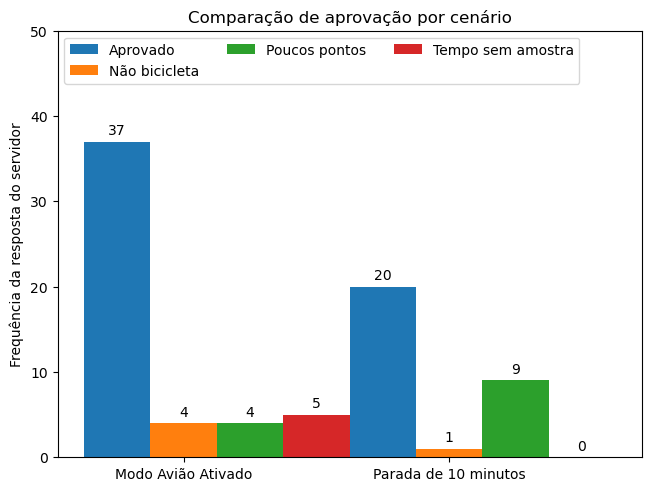

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Data Frames quando o modo avião está ativo
aprovados_modo_aviao = feedback_viagem_modo_aviao['motivooriginal'].value_counts().get('APROVADO', 0)
modo_aviao_nao_bicicleta = feedback_viagem_modo_aviao['motivooriginal'].value_counts().get('NAO_BICICLETA', 0)
modo_aviao_poucos_pontos = feedback_viagem_modo_aviao['motivooriginal'].value_counts().get('POUCOS_PONTOS', 0)
modo_aviao_tempo_sem_amostra = feedback_viagem_modo_aviao['motivooriginal'].value_counts().get('TEMPO_SEM_AMOSTRA', 0)

# Data Frames quando houve uma pausa de 10 minutos
aprovados_parada_10_minutos = feedback_viagem_parada_10_minutos['motivooriginal'].value_counts().get('APROVADO', 0)
parada_10_minutos_nao_bicicleta = feedback_viagem_parada_10_minutos['motivooriginal'].value_counts().get('NAO_BICICLETA', 0)
parada_10_minutos_poucos_pontos = feedback_viagem_parada_10_minutos['motivooriginal'].value_counts().get('POUCOS_PONTOS', 0)
parada_10_minutos_tempo_sem_amostra = feedback_viagem_parada_10_minutos['motivooriginal'].value_counts().get('TEMPO_SEM_AMOSTRA', 0)

print(viagem['motivostatus'].unique())

cenarios = ["Modo Avião Ativado", "Parada de 10 minutos"]
respostaServidor = {
    'Aprovado': (aprovados_modo_aviao, aprovados_parada_10_minutos),
    'Não bicicleta': (modo_aviao_nao_bicicleta, parada_10_minutos_nao_bicicleta),
    'Poucos pontos': (modo_aviao_poucos_pontos, parada_10_minutos_poucos_pontos),
    'Tempo sem amostra': (modo_aviao_tempo_sem_amostra, parada_10_minutos_tempo_sem_amostra)
}

x = np.arange(len(cenarios))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for atribute, measurement in respostaServidor.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=atribute)
    ax.bar_label(rects, padding=3)
    multiplier +=1

ax.set_ylabel('Frequência da resposta do servidor')
ax.set_title('Comparação de aprovação por cenário')
ax.set_xticks(x + width, cenarios)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 50)

plt.show()

## Percentual de aprovação por cenário

Dados os totais de aprovação e as reprovações pelo servidor, queremos torná-los mais visuais

In [45]:
volume_amostra_modo_aviao = aprovados_modo_aviao + modo_aviao_nao_bicicleta + modo_aviao_poucos_pontos + modo_aviao_tempo_sem_amostra
volume_amostra_parada_10_minutos = aprovados_parada_10_minutos + parada_10_minutos_nao_bicicleta + parada_10_minutos_poucos_pontos + parada_10_minutos_tempo_sem_amostra

percentual_aprovacao_modo_aviao = aprovados_modo_aviao / volume_amostra_modo_aviao * 100
percentual_aprovacao_parada_10_minutos = aprovados_parada_10_minutos / volume_amostra_parada_10_minutos * 100

print(f"Percentual de aprovação com modo avião ativo: {percentual_aprovacao_modo_aviao}")
print(f"Percentual de aprovação com uma parada de 10 minutos: {percentual_aprovacao_parada_10_minutos}")

Percentual de aprovação com modo avião ativo: 74.0
Percentual de aprovação com uma parada de 10 minutos: 66.66666666666666


In [46]:
percentual_reprovacao_modo_aviao = 100 - percentual_aprovacao_modo_aviao
percentual_reprovacao_parada_10_minutos = 100 - percentual_aprovacao_parada_10_minutos

amostra_sem_modo_aviao = viagem.sample(volume_amostra_modo_aviao)
amostra_sem_parada_10_minutos = viagem.sample(volume_amostra_parada_10_minutos)

aprovados_amostra_sem_modo_aviao = amostra_sem_modo_aviao[amostra_sem_modo_aviao['motivostatus'] == 'APROVADO'].shape[0]
reprovados_amostra_sem_modo_aviao = amostra_sem_modo_aviao[(amostra_sem_modo_aviao['motivostatus'] != 'ORIGEM_IGUAL_DESTINO') &
                                                   (amostra_sem_modo_aviao['motivostatus'] != 'VIAGEM_VALIDACAO') &
                                                   (amostra_sem_modo_aviao['motivostatus'] != 'LIMITE_VIAGENS_EXCEDIDO') &
                                                   (amostra_sem_modo_aviao['motivostatus'] != 'PILOTO_NAO_INICIADO')].shape[0]

aprovados_amostra_sem_parada_10_minutos = amostra_sem_parada_10_minutos[amostra_sem_parada_10_minutos['motivostatus'] == 'APROVADO'].shape[0]
reprovados_amostra_sem_parada_10_minutos = amostra_sem_parada_10_minutos[(amostra_sem_parada_10_minutos['motivostatus'] != 'ORIGEM_IGUAL_DESTINO') &
                                                   (amostra_sem_parada_10_minutos['motivostatus'] != 'VIAGEM_VALIDACAO') &
                                                   (amostra_sem_parada_10_minutos['motivostatus'] != 'LIMITE_VIAGENS_EXCEDIDO') &
                                                   (amostra_sem_parada_10_minutos['motivostatus'] != 'PILOTO_NAO_INICIADO')].shape[0]


percentual_aprovacao_amostra_sem_modo_aviao = aprovados_amostra_sem_modo_aviao / (reprovados_amostra_sem_modo_aviao + aprovados_amostra_sem_modo_aviao) * 100
percentual_aprovacao_amostra_sem_parada_10_minutos = aprovados_amostra_sem_parada_10_minutos / (reprovados_amostra_sem_parada_10_minutos + aprovados_amostra_sem_parada_10_minutos) * 100

percentual_reprovacao_amostra_sem_modo_aviao = 100 - percentual_aprovacao_amostra_sem_modo_aviao
percentual_reprovacao_amostra_sem_parada_10_minutos = 100 - percentual_aprovacao_amostra_sem_parada_10_minutos

print(f"Percentual de aprovação sem modo avião: {percentual_aprovacao_amostra_sem_modo_aviao}")
print(f"Percentual de aprovação sem parada de 10 minutos: {percentual_aprovacao_amostra_sem_parada_10_minutos}")

Percentual de aprovação sem modo avião: 40.42553191489361
Percentual de aprovação sem parada de 10 minutos: 42.857142857142854


### Aprovação **com** modo avião vs **sem** modo avião

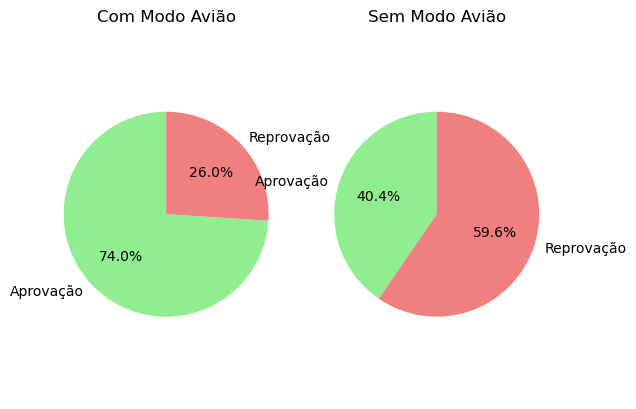

In [47]:
labels_modo_aviao = ['Aprovação', 'Reprovação']
sizes_modo_aviao = [percentual_aprovacao_modo_aviao, percentual_reprovacao_modo_aviao]
colors_modo_aviao = ['lightgreen', 'lightcoral']

plt.subplot(1, 2, 1)
plt.pie(sizes_modo_aviao, labels=labels_modo_aviao, colors=colors_modo_aviao, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Com Modo Avião')

labels_parada_10_minutos = ['Aprovação', 'Reprovação']
sizes_parada_10_minutos = [percentual_aprovacao_amostra_sem_modo_aviao, percentual_reprovacao_amostra_sem_modo_aviao]
colors_parada_10_minutos = ['lightgreen', 'lightcoral']

plt.subplot(1, 2, 2)
plt.pie(sizes_parada_10_minutos, labels=labels_parada_10_minutos, colors=colors_parada_10_minutos, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Sem Modo Avião')

plt.show()

### Aprovação **com** parada de 10 minutos vs. **sem** parada de 10 minutos

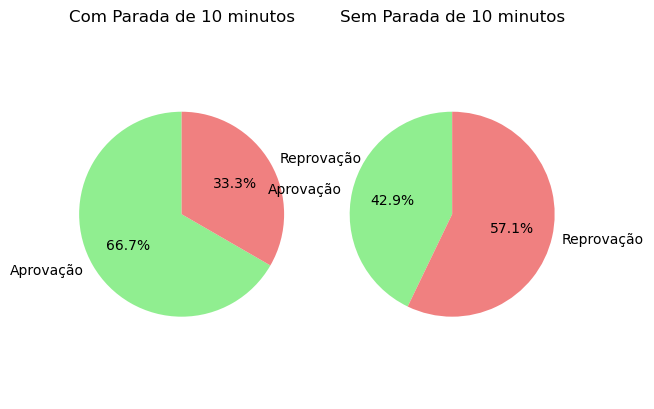

In [48]:
labels_modo_aviao = ['Aprovação', 'Reprovação']
sizes_modo_aviao = [percentual_aprovacao_parada_10_minutos, percentual_reprovacao_parada_10_minutos]
colors_modo_aviao = ['lightgreen', 'lightcoral']

plt.subplot(1, 2, 1)
plt.pie(sizes_modo_aviao, labels=labels_modo_aviao, colors=colors_modo_aviao, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Com Parada de 10 minutos')

labels_parada_10_minutos = ['Aprovação', 'Reprovação']
sizes_parada_10_minutos = [percentual_aprovacao_amostra_sem_parada_10_minutos, percentual_reprovacao_amostra_sem_parada_10_minutos]
colors_parada_10_minutos = ['lightgreen', 'lightcoral']

plt.subplot(1, 2, 2)
plt.pie(sizes_parada_10_minutos, labels=labels_parada_10_minutos, colors=colors_parada_10_minutos, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Sem Parada de 10 minutos')

plt.show()

## Teste de Hipótese sobre os dois cenários

Queremos comparar a influência dos cenários na precisão de resposta do servidor. Para isso, utilizaremos o conceito estatístico de teste de hipótese.

Como temos um conjunto relativamente grande de dados e queremos medir as "proporções" de aprovações, julgamos conviniênte utilizar o teste de Proporções

In [49]:
seed = 42

random.seed(seed)

index_aleatorio_sem_modo_aviao = [random.randint(0, viagem['idviagem'].size) for _ in range(volume_amostra_modo_aviao)]
index_aleatorio_sem_parada_10_minutos = [random.randint(0, viagem['idviagem'].size) for _ in range(volume_amostra_parada_10_minutos)]

aprovados_sem_modo_aviao = sum(viagem.loc[index_aleatorio_sem_modo_aviao, 'motivostatus'] == 'APROVADO')
aprovados_sem_parada_10_minutos = sum(viagem.loc[index_aleatorio_sem_parada_10_minutos, 'motivostatus'] == 'APROVADO')

### Modo Avião

**Hipotese Nula** (H_0): O modo avião não afeta o status de aprovação

**Hipotese Alternativa** (H_1): O modo avião afeta o status de aprovação

In [50]:
stat_modo_aviao, p_valor_modo_aviao = proportions_ztest([aprovados_modo_aviao, aprovados_sem_modo_aviao], [volume_amostra_modo_aviao, volume_amostra_modo_aviao])

print(f"Estatística de teste: {stat_modo_aviao}")
print(f"p-valor: {p_valor_modo_aviao}")

print('\n')

alpha = 0.05
if p_valor_modo_aviao < alpha:
    print("Rejeitar H_0: Existem evidências estatísticas de que o modo avião afeta o status de aprovação.")
else:
    print("Aceitar H_0: Não existem evidências estatísticas de que o modo avião afeta o status de aprovação.")

Estatística de teste: 1.6888013236829966
p-valor: 0.09125751009436339


Aceitar H_0: Não existem evidências estatísticas de que o modo avião afeta o status de aprovação.


### Parada de 10 minutos

**Hipostese Nula** (H_0): A parada não afeta o status de aprovação

**Hipostese Alternativa** (H_1): A parada afeta o status de aprovação

In [51]:
stat_parada_10_minutos, p_valor_parada_10_minutos = proportions_ztest([aprovados_parada_10_minutos, aprovados_sem_parada_10_minutos], [volume_amostra_parada_10_minutos, volume_amostra_parada_10_minutos])

print(f"Estatística de teste: {stat_parada_10_minutos}")
print(f"p-valor: {p_valor_parada_10_minutos}")

print('\n')

alpha = 0.05
if p_valor_parada_10_minutos < alpha:
    print("Rejeitar H_0: Existem evidências estatísticas de que a parada de 10 minutos afetam o status de aprovação")
else:
    print("Aceitar H_0: Não existem evidências estatísticas de que a parada de 10 minutos afetam o status de aprovação")

Estatística de teste: 1.563150317156718
p-valor: 0.11801724285265297


Aceitar H_0: Não existem evidências estatísticas de que a parada de 10 minutos afetam o status de aprovação


# Comparação da eficácia do Activity Recognition

Iremos separar o conjunto de dados viagem_sem_trajeto_sem_activity.csv em dois grupos, cujo activityrecognitiontrip foi usado e outro no qual a aprovação contou unicamente com os dados do trajeto.

Consideramos neste estudo as respostas do servidor que não são erros do usuário como 'ORIGEM_IGUAL_DESTINO' e 'LIMITES_VIAGEM_EXCEDIDO', e procedimento do servidor, como 'VIAGEM_VALIDACAO' e 'PILOTO_NAO_INICIADO'.

In [59]:
total_com_activity = viagem[(viagem['activityrecognitiontrip'] == 't') & (viagem['motivostatus'] != 'ORIGEM_IGUAL_DESTINO') & (viagem['motivostatus'] != 'VIAGEM_VALIDACAO') & (viagem['motivostatus'] != 'LIMITE_VIAGENS_EXCEDIDO') & (viagem['motivostatus'] != 'PILOTO_NAO_INICIADO')].shape[0]
total_sem_activity = viagem[(viagem['activityrecognitiontrip'] == 'f') & (viagem['motivostatus'] != 'ORIGEM_IGUAL_DESTINO') & (viagem['motivostatus'] != 'VIAGEM_VALIDACAO') & (viagem['motivostatus'] != 'LIMITE_VIAGENS_EXCEDIDO') & (viagem['motivostatus'] != 'PILOTO_NAO_INICIADO')].shape[0]

aprovados_com_activity = viagem[(viagem['motivostatus'] == 'APROVADO') & (viagem['activityrecognitiontrip'] == 't')].shape[0]
aprovados_sem_activity = viagem[(viagem['motivostatus'] == 'APROVADO') & (viagem['activityrecognitiontrip'] == 'f')].shape[0]

## Percentual de aprovação **com** e **sem** activity

Tomando amostras dos dados coletados, queremos identificar se houveram mais aprovações com o uso do activities

In [60]:
amostra_com_activity = viagem[(viagem['activityrecognitiontrip'] == 't')].sample(50)
amostra_sem_activity = viagem[(viagem['activityrecognitiontrip'] == 'f')].sample(50)

amostra_aprovados_com_activity = amostra_com_activity[(amostra_com_activity['motivostatus'] == 'APROVADO')].shape[0]
amostra_aprovados_sem_activity = amostra_sem_activity[(amostra_sem_activity['motivostatus'] == 'APROVADO')].shape[0]

volume_amostra_com_activity = amostra_com_activity[(amostra_com_activity['motivostatus'] != 'ORIGEM_IGUAL_DESTINO') &
                                                   (amostra_com_activity['motivostatus'] != 'VIAGEM_VALIDACAO') &
                                                   (amostra_com_activity['motivostatus'] != 'LIMITE_VIAGENS_EXCEDIDO') &
                                                   (amostra_com_activity['motivostatus'] != 'PILOTO_NAO_INICIADO')].shape[0]
volume_amostra_sem_activity = amostra_sem_activity[(amostra_sem_activity['motivostatus'] != 'ORIGEM_IGUAL_DESTINO') &
                                                   (amostra_sem_activity['motivostatus'] != 'VIAGEM_VALIDACAO') &
                                                   (amostra_sem_activity['motivostatus'] != 'LIMITE_VIAGENS_EXCEDIDO') &
                                                   (amostra_sem_activity['motivostatus'] != 'PILOTO_NAO_INICIADO')].shape[0]

percentual_aprovados_com_activity = (amostra_aprovados_com_activity / volume_amostra_com_activity) * 100
percentual_aprovados_sem_activity = (amostra_aprovados_sem_activity / volume_amostra_sem_activity) * 100

print(f"Volume de dados COM activity: {total_com_activity}")
print(f"Volume de dados SEM activity: {total_sem_activity}\n")

print(f"Porcentual de aprovação com activity: {percentual_aprovados_com_activity}")
print(f"Porcentual de aprovação sem activity: {percentual_aprovados_sem_activity}")

Volume de dados COM activity: 315
Volume de dados SEM activity: 187

Porcentual de aprovação com activity: 41.02564102564102
Porcentual de aprovação sem activity: 90.32258064516128


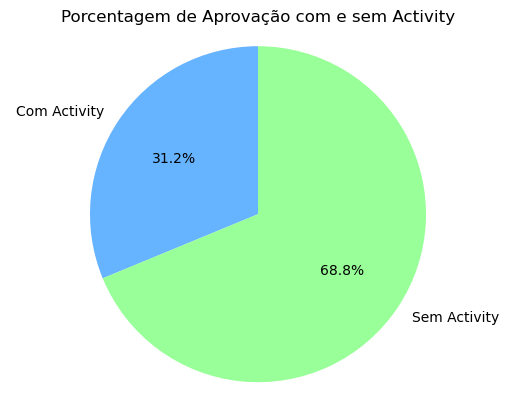

In [61]:
labels = ['Com Activity', 'Sem Activity']
percentuais = [percentual_aprovados_com_activity, percentual_aprovados_sem_activity]

cores = ['#66b3ff', '#99ff99']

fig1, ax1 = plt.subplots()
ax1.pie(percentuais, labels=labels, autopct="%1.1f%%", startangle=90, colors=cores)

ax1.axis('equal')

plt.title('Porcentagem de Aprovação com e sem Activity')

plt.show()

## Teste de Hipotese sobre aprovações

Queremos descobrir se o uso do Activity Recognition Trip afeta nas aprovações das viagens. Para isso, utilizamos o teste de proporções a fim de verificar se a proporção de viagens aprovados foi afetado no 

In [55]:
stat_activity, p_valor_activity = proportions_ztest([aprovados_com_activity, aprovados_sem_activity], [total_com_activity, total_sem_activity])

alpha = 0.05

print(f"Estatística de teste: {abs(stat_activity)}")
print(f"p-valor: {p_valor_activity}")

print('\n')

alpha = 0.05

if p_valor_activity < alpha:
    print("Rejeitar H_0: Existem evidências estatísticas de que o Activity Recognition trip afeta o status de aprovação")
else:
    print("Aceitar H_0: Não existem evidências estatísticas de que o Activity Recognition trip afeta o status de aprovação")

Estatística de teste: 11.146412984835793
p-valor: 7.455145656712323e-29


Rejeitar H_0: Existem evidências estatísticas de que o Activity Recognition trip afeta o status de aprovação


## Percentual de identificação de **NAO_BICICLETA**

Um dos principais motivos do uso do Activity Recognition Trip foi a precisão da detecção do uso da bicicleta.

Aqui queremos ver a eficiência da mudança